# ArXiv API

The ArXiV API allows programmatic access to the arXiv's e-print content and metadata. "The goal of the interface is to facilitate new and creative use of the the vast body of material on the arXiv by providing a low barrier to entry for application developers." https://arxiv.org/help/api

The API's user manual (https://arxiv.org/help/api/user-manual) provides helpful documentation for using the API and retrieving article metadata.

Our examples below will introduce you to the basics of querying the ArXiV API.

# Install Packages

In [103]:
import urllib
import arxiv
import requests
import json
import csv
import pandas as pd
from collections import Counter, defaultdict
import numpy as np # for array manipulation
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline 
import datetime

# Query the API

Perform a simple query for graphene. We'll limit results to 100. Take a look at the information you get back and how it is structured.

In [131]:
graphene = arxiv.query(query="graphene", max_results=100)
graphene

[{'id': 'http://arxiv.org/abs/1905.03965v3',
  'guidislink': True,
  'updated': '2019-10-04T10:10:03Z',
  'updated_parsed': time.struct_time(tm_year=2019, tm_mon=10, tm_mday=4, tm_hour=10, tm_min=10, tm_sec=3, tm_wday=4, tm_yday=277, tm_isdst=0),
  'published': '2019-05-10T06:41:03Z',
  'published_parsed': time.struct_time(tm_year=2019, tm_mon=5, tm_mday=10, tm_hour=6, tm_min=41, tm_sec=3, tm_wday=4, tm_yday=130, tm_isdst=0),
  'title': 'Hydrogenated-Graphene encapsulated Graphene: A versatile material for\n  device applications',
  'title_detail': {'type': 'text/plain',
   'language': None,
   'base': 'http://export.arxiv.org/api/query?search_query=graphene&id_list=&start=0&max_results=100&sortBy=relevance&sortOrder=descending',
   'value': 'Hydrogenated-Graphene encapsulated Graphene: A versatile material for\n  device applications'},
  'summary': 'Graphene and its heterostructures exhibit interesting electronic properties\nand are explored for quantum spin Hall effect(QSHE) and magn

Do another query for the topic "quantum dots", while noting how you can manipulate results if you desire.

In [38]:

quantum_dots = arxiv.query(
  query="quantum dots",
  id_list=[],
  max_results=None,
  start = 0,
  sort_by="relevance",
  sort_order="descending",
  prune=True,
  iterative=False,
  max_chunk_results=1000
)

# Organize and analyze your results

Create a dataframe to better analyze your results.

In [133]:
qd_df = pd.DataFrame(quantum_dots)

We'll look at the first 10 results.

In [134]:
qd_df.head(10)

,id,guidislink,updated,updated_parsed,published,published_parsed,title,title_detail,summary,summary_detail,...,author,arxiv_comment,links,arxiv_primary_category,tags,pdf_url,affiliation,arxiv_url,journal_reference,doi
0,http://arxiv.org/abs/1812.08931v1,True,2018-12-21T03:50:15Z,"(2018, 12, 21, 3, 50, 15, 4, 355, 0)",2018-12-21T03:50:15Z,"(2018, 12, 21, 3, 50, 15, 4, 355, 0)",Band Modulation for Silicene and Graphene Quan...,"{'type': 'text/plain', 'language': None, 'base...",The band modulation of the silicene and graphe...,"{'type': 'text/plain', 'language': None, 'base...",...,Bi-Ru Wu,"3 pages, 5 figures","[{'href': 'http://arxiv.org/abs/1812.08931v1',...","{'term': 'cond-mat.mes-hall', 'scheme': 'http:...","[{'term': 'cond-mat.mes-hall', 'scheme': 'http...",http://arxiv.org/pdf/1812.08931v1,None,http://arxiv.org/abs/1812.08931v1,None,None
1,http://arxiv.org/abs/0804.1249v2,True,2008-06-16T09:34:43Z,"(2008, 6, 16, 9, 34, 43, 0, 168, 0)",2008-04-08T12:38:21Z,"(2008, 4, 8, 12, 38, 21, 1, 99, 0)",Using spin bias to manipulate and measure quan...,"{'type': 'text/plain', 'language': None, 'base...",A double-quantum-dot coupled to electrodes wit...,"{'type': 'text/plain', 'language': None, 'base...",...,Shun-Qing Shen,None,"[{'title': 'doi', 'href': 'http://dx.doi.org/1...","{'term': 'cond-mat.mes-hall', 'scheme': 'http:...","[{'term': 'cond-mat.mes-hall', 'scheme': 'http...",http://arxiv.org/pdf/0804.1249v2,None,http://arxiv.org/abs/0804.1249v2,"PHYSICAL REVIEW B 77, 235309 (2008)",10.1103/PhysRevB.77.235309
2,http://arxiv.org/abs/1710.03378v1,True,2017-10-10T02:14:16Z,"(2017, 10, 10, 2, 14, 16, 1, 283, 0)",2017-10-10T02:14:16Z,"(2017, 10, 10, 2, 14, 16, 1, 283, 0)",Co-tunneling spin blockade observed in a three...,"{'type': 'text/plain', 'language': None, 'base...",We prepare a triple quantum dot with a separat...,"{'type': 'text/plain', 'language': None, 'base...",...,S. Tarucha,None,"[{'title': 'doi', 'href': 'http://dx.doi.org/1...","{'term': 'cond-mat.mes-hall', 'scheme': 'http:...","[{'term': 'cond-mat.mes-hall', 'scheme': 'http...",http://arxiv.org/pdf/1710.03378v1,None,http://arxiv.org/abs/1710.03378v1,"Phys. Rev. B 96, 155414 (2017)",10.1103/PhysRevB.96.155414
3,http://arxiv.org/abs/cond-mat/0310363v1,True,2003-10-15T20:15:59Z,"(2003, 10, 15, 20, 15, 59, 2, 288, 0)",2003-10-15T20:15:59Z,"(2003, 10, 15, 20, 15, 59, 2, 288, 0)",Excitonic properties of strained wurtzite and ...,"{'type': 'text/plain', 'language': None, 'base...",We investigate exciton states theoretically in...,"{'type': 'text/plain', 'language': None, 'base...",...,Alexander A. Balandin,"18 pages, accepted for publication in the Jour...","[{'title': 'doi', 'href': 'http://dx.doi.org/1...","{'term': 'cond-mat.mes-hall', 'scheme': 'http:...","[{'term': 'cond-mat.mes-hall', 'scheme': 'http...",http://arxiv.org/pdf/cond-mat/0310363v1,None,http://arxiv.org/abs/cond-mat/0310363v1,"J. Appl. Phys. 94, 7178 (2003)",10.1063/1.1623330
4,http://arxiv.org/abs/cond-mat/0002155v3,True,2000-07-12T06:57:56Z,"(2000, 7, 12, 6, 57, 56, 2, 194, 0)",2000-02-10T17:42:21Z,"(2000, 2, 10, 17, 42, 21, 3, 41, 0)",Solution of the Schrödinger Equation for Quant...,"{'type': 'text/plain', 'language': None, 'base...","The Schr\""odinger equation for quantum dot lat...","{'type': 'text/plain', 'language': None, 'base...",...,M. Taut,11 figures included as ps-files,"[{'title': 'doi', 'href': 'http://dx.doi.org/1...","{'term': 'cond-mat.mes-hall', 'scheme': 'http:...","[{'term': 'cond-mat.mes-hall', 'scheme': 'http...",http://arxiv.org/pdf/cond-mat/0002155v3,None,http://arxiv.org/abs/cond-mat/0002155v3,"Phys. Rev. B 62, 8126 (2000)",10.1103/PhysRevB.62.8126
5,http://arxiv.org/abs/cond-mat/9907055v1,True,1999-07-04T11:37:16Z,"(1999, 7, 4, 11, 37, 16, 6, 185, 0)",1999-07-04T11:37:16Z,"(1999, 7, 4, 11, 37, 16, 6, 185, 0)",Quantum dot dephasing by edge states,"{'type': 'text/plain', 'language': None, 'base...",We calculate the dephasing rate of an electron...,"{'type': 'text/plain', 'language

Next, we'll call a list of all of the columns in the dataframe to see what else is there:

In [128]:
list(qd_df)

['id',
 'guidislink',
 'updated',
 'updated_parsed',
 'published',
 'published_parsed',
 'title',
 'title_detail',
 'summary',
 'summary_detail',
 'authors',
 'author_detail',
 'author',
 'arxiv_comment',
 'links',
 'arxiv_primary_category',
 'tags',
 'pdf_url',
 'affiliation',
 'arxiv_url',
 'journal_reference',
 'doi']

We have 22 columns overall. Let's look at article title, id, date published and url.

In [129]:
qd_df = qd_df[['title', 'published', 'author', 'pdf_url']]
qd_df

,title,published,author,pdf_url
0,Band Modulation for Silicene and Graphene Quan...,2018-12-21T03:50:15Z,Bi-Ru Wu,http://arxiv.org/pdf/1812.08931v1
1,Using spin bias to manipulate and measure quan...,2008-04-08T12:38:21Z,Shun-Qing Shen,http://arxiv.org/pdf/0804.1249v2
2,Co-tunneling spin blockade observed in a three...,2017-10-10T02:14:16Z,S. Tarucha,http://arxiv.org/pdf/1710.03378v1
3,Excitonic properties of strained wurtzite and ...,2003-10-15T20:15:59Z,Alexander A. Balandin,http://arxiv.org/pdf/cond-mat/0310363v1
4,Solution of the Schrödinger Equation for Quant...,2000-02-10T17:42:21Z,M. Taut,http://arxiv.org/pdf/cond-mat/0002155v3
...,...,...,...,...
4995,Probing Entanglement and Non-locality of Elect...,1999-07-08T21:02:51Z,Eugene V. Sukhorukov,http://arxiv.org/pdf/cond-mat/9907129v2
4996,Magnetoplasmon excitations in arrays of circul...,1999-08-17T00:47:24Z,D. A. W. Hutchinson,http://arxiv.org/pdf/cond-mat/9908235v1
4997,Interpolative method for transport properties ...,1999-10-13T13:48:40Z,F. Flores,http://arxiv.org/pdf/cond-mat/9910190v1
4998,Sequential magnetotunneling in a vertical Quan...,1999-11-15T17:35:30Z,A. Tagliacozzo,http://arxiv.org/pdf/cond-mat/9911224v1


# Visualize your results

Get a sense of the how your topic has trended over time. When did research on your topic take off?
Assign datetime functionality to the column "published" which lists when the article was published and then create a bar chart.

In [44]:
qd_df["published"] = qd_df["published"].astype("datetime64")

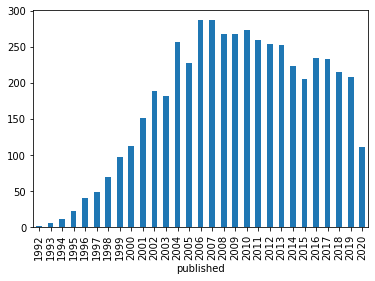

In [46]:
qd_df["published"].groupby(qd_df["published"].dt.year).count().plot(kind="bar")

Explore authors to see who is publishing your topic. Group by author, then sort and select the top 20 authors.

In [97]:
qd_authors = qd_df.groupby(qd_df["author"])["author"].count().sort_values(ascending=False)
qd_authors.head(20)

author
Daniel Loss             50
A. C. Gossard           38
S. Das Sarma            32
F. M. Peeters           25
Jelena Vuckovic         25
Jürgen König            24
S. Tarucha              23
Paweł Machnikowski      23
Guido Burkard           21
L. M. K. Vandersypen    21
J. J. Finley            20
Pawel Hawrylak          20
L. P. Kouwenhoven       20
Seigo Tarucha           20
A. Imamoglu             18
R. J. Haug              18
B. Szafran              17
Xuedong Hu              17
P. M. Petroff           17
A. J. Shields           17
Name: author, dtype: int64

# Identify and download papers

Let's look at the papers by Tarucha and download the oldest one:

In [98]:
qd_Tarucha = qd_df[qd_df['author']=='S. Tarucha'].sort_values('published')
qd_Tarucha

,title,published,author,pdf_url
3740,Excitation Spectra of Circular Few-Electron Qu...,1997-08-29T12:27:44Z,S. Tarucha,http://arxiv.org/pdf/cond-mat/9708229v1
3965,Stability of the maximum density droplet in qu...,1998-10-14T12:19:42Z,S. Tarucha,http://arxiv.org/pdf/cond-mat/9810159v1
3386,Intermediate Low Spin States in a Few-electron...,2005-12-12T06:16:28Z,S. Tarucha,http://arxiv.org/pdf/cond-mat/0512239v1
4593,Micro-magnets for coherent control of spin-cha...,2006-12-13T08:14:16Z,S. Tarucha,http://arxiv.org/pdf/cond-mat/0612314v1
3406,Large nuclear Overhauser fields detected in ve...,2007-05-08T19:51:57Z,S. Tarucha,http://arxiv.org/pdf/0705.1104v2
2143,Two level anti-crossings high up in the single...,2007-10-04T15:43:34Z,S. Tarucha,http://arxiv.org/pdf/0710.1035v1
4182,Lateral electron tunneling through single self...,2007-11-13T10:08:55Z,S. Tarucha,http://arxiv.org/pdf/0711.1945v1
2857,Accurate Model of a Vertical Pillar Quantum Dot,2008-04-20T13:54:34Z,S. Tarucha,http://arxiv.org/pdf/0804.3191v1
753,Gate Adjustable Coherent Three and Four Level ...,2009-08-31T15:42:02Z,S. Tarucha,http://arxiv.org/pdf/0908.4561v1
430,Dephasing in an Aharonov-Bohm interferometer c...,2010-05-12T23:21:06Z,S. Tarucha,http://arxiv.org/pdf/1005.2226v1


In [99]:
paper = {"pdf_url": "http://arxiv.org/pdf/cond-mat/9708229v1",
          "title": "Excitation Spectra"}
arxiv.download(paper)

'./9708229v1.Excitation_Spectra.pdf'

Confirm that the pdf has downloaded!

# Bibliography

- Tim Head: https://betatim.github.io/posts/analysing-the-arxiv/
- Lukas Schwab: https://github.com/lukasschwab/arxiv.py
- ArXiV API user manual: https://arxiv.org/help/api/user-manual        